In [1]:
import numpy as np
import do_mpc
from DifferentialDriveExperiment import DifferentialDriveExperiment 
import baseline_integration as bi

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/root/miniconda3/envs/dompc_dev/lib/python3.6/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.



/root/miniconda3/envs/dompc_dev/lib/python3.6/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Arrived in 419 steps
Ho 419 obss e 418 actions
Starting point: x:0.12, y:-0.25 -PURPLE-
End point: x:0.06884662644895297, y:-0.07132355269511192 -GREEN-


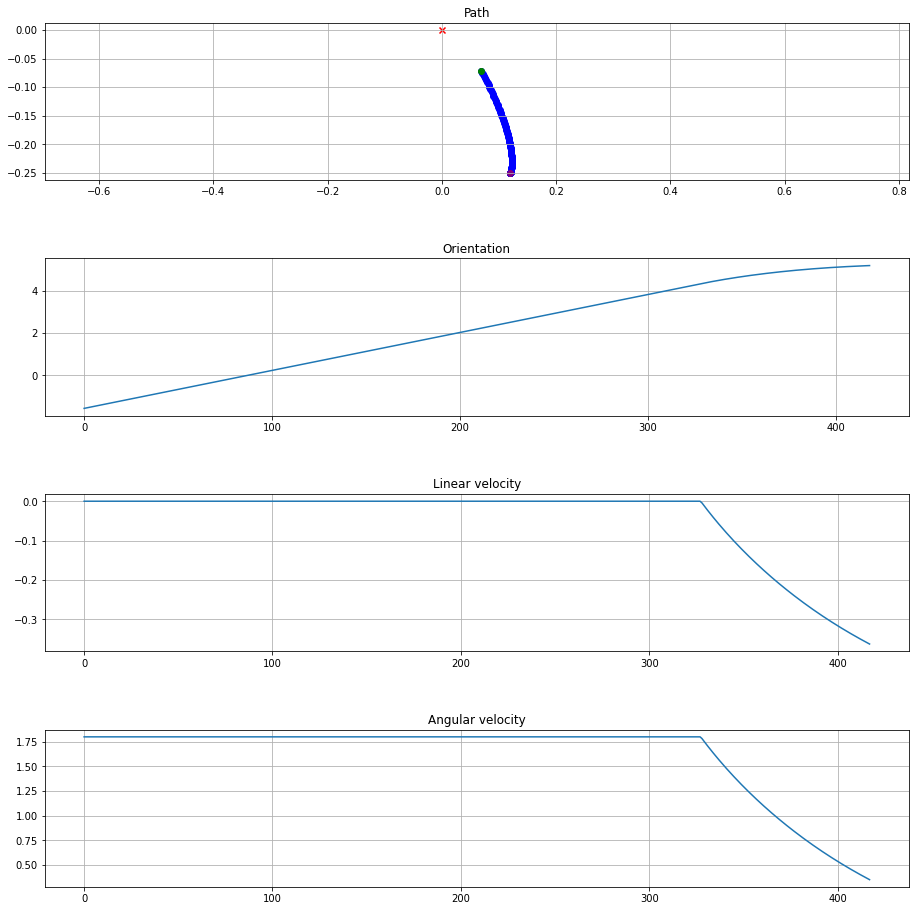

In [2]:
ppo2_model_name = "ppo2_meters_redesigned_1"
init_robot_pose = {'x': 0.12, 'y': -0.25, 'theta': -np.pi/2}
obss, actions = bi.load_and_run_model(ppo2_model_name,500,list(init_robot_pose.values()))
print("Ho {} obss e {} actions".format(len(obss),len(actions)))
bi.show_rl_trajectory(obss,actions)

In [3]:
experiment = DifferentialDriveExperiment(axle_lengths_dict={'values':[0.5,0.49]}, wheel_radii_dict={'values':[0.15]},
                                         tracking_trajectories=[{'L':0.5,'r':0.15,'path':obss,'actions':actions}
                                                               ])
print("Quanti punti ho: {} ".format(len(experiment.tracking_trajectories[0]['path'])))
print("Trajectory Mode {}".format(experiment.tracking_trajectory_mode))
print("Scenario track {}".format(experiment.scenario_based_trajectory_tracking))
experiment.setup_experiment(init_robot_pose)
graphic_output_file = '20210429_tracking_ddrive.gif'

ok both weights are not assigned so the library will assign the same prob to each scenario
Quanti punti ho: 419 
Trajectory Mode True
Scenario track False
dict_values([0.12, -0.25, -1.5707963267948966])
[[ 0.12      ]
 [-0.25      ]
 [-1.57079633]]


In [4]:
mpc_graphics = do_mpc.graphics.Graphics(experiment.mpc.data)

In [5]:
import matplotlib.pyplot as plt
plt.ion() # interactive mode on
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

# Include these parameters in order to have embedded animations without saving the gif file
rcParams["animation.html"] = "jshtml"
rcParams['animation.embed_limit'] = 2**128

In [6]:
def differential_drive_robot(x, L, r):
    x = x.flatten()
    theta = x[2]
    
    length = 5
    endx = x[0] + length * np.cos(theta)
    endy = x[1] + length * np.sin(theta)
    
    # Get the x,y coordinates of the 2 bars for the given state x
    orientation_x = np.array([
        x[0],
        endx
    ])
    
    orientation_y = np.array([
        x[1],
        endy
    ])
    
    
    left_wheel = np.array([x[0]+L/2*np.cos(theta+np.pi/2),x[1]+L/2*np.sin(theta+np.pi/2)])
    right_wheel = np.array([x[0]+L/2*np.cos(theta-np.pi/2),x[1]+L/2*np.sin(theta-np.pi/2)])

    bar_x = np.array([
        right_wheel[0],
        left_wheel[0]        
    ])
    
    bar_y = np.array([
        right_wheel[1],
        left_wheel[1]     
    ])
    
    left_wheel_front = np.array([left_wheel[0]+r*np.cos(theta),left_wheel[1]+r*np.sin(theta)])
    left_wheel_back = np.array([left_wheel[0]-r*np.cos(theta),left_wheel[1]-r*np.sin(theta)])
    
    left_wheel_x = np.array([
        left_wheel_front[0],
        left_wheel_back[0]        
    ])
    
    left_wheel_y = np.array([
        left_wheel_front[1],
        left_wheel_back[1]     
    ])
    
    right_wheel_front = np.array([right_wheel[0]+r*np.cos(theta),right_wheel[1]+r*np.sin(theta)])
    right_wheel_back = np.array([right_wheel[0]-r*np.cos(theta),right_wheel[1]-r*np.sin(theta)])
    
    right_wheel_x = np.array([
        right_wheel_front[0],
        right_wheel_back[0]        
    ])
    
    right_wheel_y = np.array([
        right_wheel_front[1],
        right_wheel_back[1]     
    ])
    
    orientation = np.stack((orientation_x, orientation_y))
    bar = np.stack((bar_x, bar_y))
    left_wheel = np.stack((left_wheel_x,left_wheel_y))
    right_wheel = np.stack((right_wheel_x,right_wheel_y))
        
    return orientation, bar, left_wheel, right_wheel

In [7]:
#help(do_mpc.controller.MPC.set_uncertainty_weights)

In [8]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((5, 2), (0, 0), rowspan=5)
ax2 = plt.subplot2grid((5, 2), (0, 1))
ax3 = plt.subplot2grid((5, 2), (1, 1))
ax4 = plt.subplot2grid((5, 2), (2, 1))
ax5 = plt.subplot2grid((5, 2), (3, 1))
ax6 = plt.subplot2grid((5, 2), (4, 1))

ax2.set_ylabel('$\omega_{left}$ [rad/s]')
ax3.set_ylabel('$\omega_{right}$ [rad/s]')
ax4.set_ylabel('$v$ [m/s]')
ax5.set_ylabel('$\omega$ [rad/s]')
ax6.set_ylabel('$distance$ [m]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5, ax6]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax6:
        ax.xaxis.set_ticklabels([])

ax6.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_u', var_name='u_l', axis=ax2)
mpc_graphics.add_line(var_type='_u', var_name='u_r', axis=ax3)
mpc_graphics.add_line(var_type='_aux', var_name='v', axis=ax4)
mpc_graphics.add_line(var_type='_aux', var_name='w', axis=ax5)
#mpc_graphics.add_line(var_type='_aux', var_name='position_norm', axis=ax6)
mpc_graphics.add_line(var_type='_aux', var_name='trajectory_error', axis=ax6)
#mpc_graphics.add_line(var_type='_aux', var_name='squared_distance', axis=ax6)

ax1.axhline(0,color='black')

orientation_line = ax1.plot([],[], '-o', color = 'black',dashes = [6,2])
bar_line = ax1.plot([],[], color = 'blue')
left_wheel_line = ax1.plot([],[],'blue')
right_wheel_line = ax1.plot([],[],'blue')

ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
#ax1.set_axis_off()

ax1.set_aspect('equal')

fig.align_ylabels()
fig.tight_layout()

In [9]:
u0 = experiment.mpc.make_step(experiment.simulator.x0)

MPC TVP FUN has 1 parameters
x0 is [0.12, -0.25, -1.5708] and its type is <class 'casadi.casadi.DM'>
Make step tvp0['_tvp'] type [DM([0.12, -0.25, -1.5708, -3, 3]), DM([0.12, -0.25, -1.5528, -3, 3]), DM([0.12, -0.25, -1.5348, -3, 3]), DM([0.12, -0.25, -1.5168, -3, 3]), DM([0.12, -0.25, -1.4988, -3, 3]), DM([0.12, -0.25, -1.4808, -3, 3]), DM([0.12, -0.25, -1.4628, -3, 3]), DM([0.12, -0.25, -1.4448, -3, 3]), DM([0.12, -0.25, -1.4268, -3, 3]), DM([0.12, -0.25, -1.4088, -3, 3]), DM([0.12, -0.25, -1.3908, -3, 3]), DM([0.12, -0.25, -1.3728, -3, 3]), DM([0.12, -0.25, -1.3548, -3, 3]), DM([0.12, -0.25, -1.3368, -3, 3]), DM([0.12, -0.25, -1.3188, -3, 3]), DM([0.12, -0.25, -1.3008, -3, 3]), DM([0.12, -0.25, -1.2828, -3, 3]), DM([0.12, -0.25, -1.2648, -3, 3]), DM([0.12, -0.25, -1.2468, -3, 3]), DM([0.12, -0.25, -1.2288, -3, 3]), DM([0.12, -0.25, -1.2108, -3, 3]), DM([0.12, -0.25, -1.1928, -3, 3]), DM([0.12, -0.25, -1.1748, -3, 3]), DM([0.12, -0.25, -1.1568, -3, 3]), DM([0.12, -0.25, -1.1388, -3, 

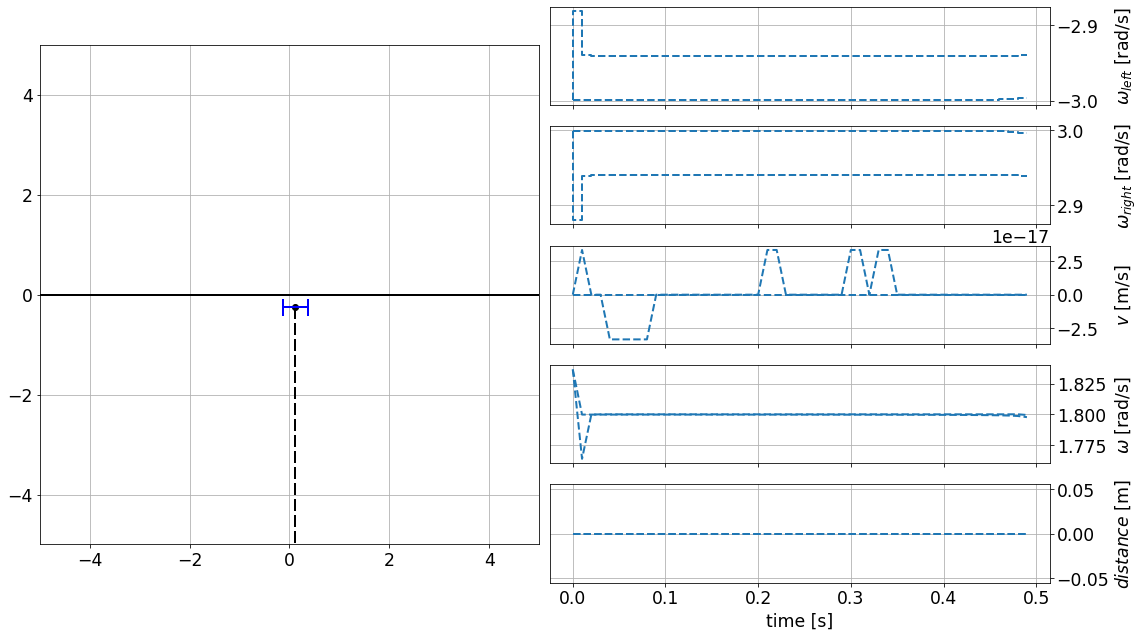

In [10]:
x0_np = experiment.simulator.x0.cat.full()
orientation, bar, left_wheel, right_wheel = differential_drive_robot(x0_np, experiment.true_axle_length, experiment.true_wheel_radius)
orientation_line[0].set_data(orientation[0], orientation[1])
bar_line[0].set_data(bar[0], bar[1])
right_wheel_line[0].set_data(right_wheel[0], right_wheel[1])
left_wheel_line[0].set_data(left_wheel[0], left_wheel[1])

mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [11]:
%%capture
# Quickly reset the history of the MPC data object.
experiment.mpc.reset_history()

n_steps = 450
x0 = experiment.simulator.x0
for k in range(n_steps):
    u0 = experiment.mpc.make_step(x0)
    y_next = experiment.simulator.make_step(u0)
    x0 = experiment.estimator.make_step(y_next)

In [12]:
x_arr = experiment.mpc.data['_x']
x_arr

array([[ 0.12      , -0.25      , -1.57079633],
       [ 0.12      , -0.25      , -1.5527988 ],
       [ 0.12      , -0.25      , -1.53480119],
       ...,
       [ 0.06882463, -0.07133513,  5.19711755],
       [ 0.06882463, -0.07133513,  5.19711755],
       [ 0.06882463, -0.07133513,  5.19711755]])

In [13]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
def update(t_ind):
    orientation, bar, left_wheel, right_wheel = differential_drive_robot(x_arr[t_ind],experiment.true_axle_length,experiment.true_wheel_radius)
    orientation_line[0].set_data(orientation[0],orientation[1])
    bar_line[0].set_data(bar[0],bar[1])
    right_wheel_line[0].set_data(right_wheel[0],right_wheel[1])
    left_wheel_line[0].set_data(left_wheel[0],left_wheel[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)

In [14]:
%%capture

fig2 = plt.figure(figsize=(16,9))
ax = fig2.add_subplot()
ax.set_aspect('equal')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_title('Followed trajectory',fontsize = 16)

ax.plot(x_arr[:,[0]],x_arr[:,[1]])

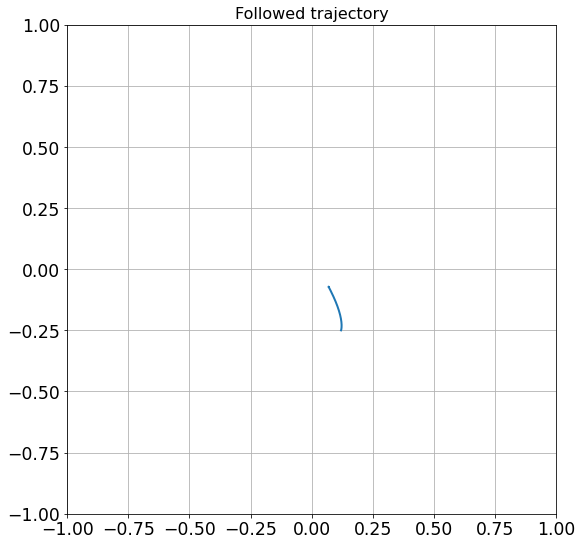

In [15]:
fig2

In [ ]:
# Show the animation as embedded without saving it as a gif
anim

In [ ]:
print("Mode {}".format(experiment.tracking_trajectory_mode))
print("Scenario track {}".format(experiment.scenario_based_trajectory_tracking))

In [ ]:
# Save the animation as a gif
gif_writer = ImageMagickWriter(fps=10)
anim.save(graphic_output_file, writer=gif_writer)

In [ ]:
!identify -list resource

In [ ]:
print(x_arr[n_steps-1])

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

In [ ]:
from pathlib import Path
gifPath = Path(graphic_output_file)
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

In [ ]:
#if there are issues in making the gif due to memory limits in ImageMagick then do the following steps:
# -- if not present, install a text editor like nano
#1- open terminal : sudo nano /etc/ImageMagick-6/policy.xml
#2- Enter your password
#3- You should be in nano file, change the line with "ressource memory" to
#4- <policy domain="resource" name="memory" value="5000MiB"/>
#5- Save the nano file : ctrl + o and enter to confirm
#6- Up the memory if necessary